<a href="https://colab.research.google.com/github/tagasy/training/blob/master/lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
import lightgbm as lgb

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,250,-0.677,1.721,-0.745,-0.838,0.149,-1.138,0.242,0.504,-1.829,-1.380,0.001,-1.340,-0.371,-0.735,-0.545,-0.525,-1.139,1.263,-0.240,0.931,-1.151,0.938,0.720,-1.543,-1.467,0.402,0.538,0.614,-0.318,-1.417,0.471,-1.139,2.294,-0.577,-0.190,-1.252,-1.708,0.415,-1.450,...,0.188,-0.756,-0.542,-0.231,0.306,-0.680,0.727,1.372,0.794,-0.930,0.652,-0.398,-0.236,1.621,0.089,-0.282,0.170,0.514,-0.321,1.038,-0.336,-1.170,0.245,-0.032,0.227,1.757,-1.513,-1.058,-0.559,0.664,-1.180,-0.403,0.759,-0.600,0.951,-0.349,0.446,-0.819,-0.277,1.297
1,251,-0.731,-0.251,0.059,0.054,1.149,2.462,0.836,0.719,-2.269,0.584,2.620,1.373,0.257,0.322,-0.009,1.844,0.576,0.686,0.095,-0.906,-0.773,-0.781,-0.659,-1.284,-0.922,-0.097,-0.464,-0.277,-0.320,0.330,-0.780,1.050,2.206,-0.587,1.220,1.350,-0.779,-0.160,0.119,...,0.513,1.831,0.584,0.482,-0.917,-0.148,-0.165,0.856,-0.029,-0.648,-0.506,0.462,-0.310,0.139,1.952,0.708,0.018,0.158,-1.415,-0.760,-0.191,-0.051,0.127,-0.340,-0.463,1.153,0.680,-0.624,-1.090,-0.681,1.297,1.114,0.657,0.760,0.899,-1.612,-1.701,1.107,-0.314,-0.641
2,252,1.119,1.036,1.220,1.518,0.265,-0.088,0.245,-0.533,-0.921,0.714,0.566,-2.343,-0.716,-1.326,-2.521,-1.481,-0.310,-0.852,-1.010,-0.814,0.549,0.113,-0.017,0.803,0.308,-0.589,1.403,0.596,1.140,-0.731,-0.785,1.103,0.690,-1.630,0.591,0.072,-1.458,0.236,0.189,...,0.174,-0.042,-1.843,-0.136,0.277,-0.537,0.010,-1.904,-1.297,0.909,0.734,-0.319,0.009,-0.534,-0.267,-1.202,-0.139,0.221,-0.473,-0.842,-0.258,1.578,-2.053,0.542,-0.524,0.840,0.088,0.957,1.394,1.761,-0.864,-0.736,0.367,0.154,0.830,-1.352,0.914,0.377,0.588,-0.912
3,253,-0.933,0.212,-0.053,0.570,-1.540,-1.108,0.462,1.022,-0.215,-0.205,-1.150,1.408,-0.625,0.296,-1.264,0.180,-0.595,0.277,2.246,2.334,1.059,-1.074,0.787,1.454,0.012,0.049,0.333,1.016,0.052,-1.179,-0.501,0.157,-0.289,-2.072,-0.827,0.091,-1.373,1.407,-1.569,...,0.554,1.532,-0.485,0.524,1.013,1.943,-1.576,0.292,-0.821,-0.395,0.728,-0.328,-0.441,0.273,-1.213,0.924,0.439,-1.023,-0.091,-0.507,-1.159,-0.644,0.037,0.518,2.475,-1.029,-0.250,0.971,-0.270,-0.500,0.063,-0.958,0.762,-0.213,-2.171,0.830,1.435,0.125,2.782,0.619
4,254,-0.208,-0.556,2.641,0.853,-0.384,0.312,0.514,0.481,-1.929,-0.400,0.636,0.580,-0.464,-0.102,-0.577,-0.095,0.696,-0.378,1.628,0.770,-0.355,0.426,0.882,-2.685,-0.043,-0.665,1.905,0.726,-1.239,0.615,-0.262,0.800,0.529,-0.883,-2.015,1.083,-0.402,0.839,0.931,...,0.017,-0.860,0.739,-0.803,-0.925,1.020,-0.056,-0.214,1.165,-0.494,0.700,-0.274,-1.253,-0.624,-2.015,0.057,-1.496,-0.068,0.698,0.236,-0.506,-0.367,-1.885,-0.541,-0.387,-1.306,-0.155,0.476,-1.131,0.080,-0.689,0.213,0.568,-0.935,-0.015,0.267,0.739,1.340,-0.178,1.010


In [0]:
X = train.drop(['id', 'target'], axis=1)
y = train['target']

test = test.drop(['id'], axis=1)
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.677,1.721,-0.745,-0.838,0.149,-1.138,0.242,0.504,-1.829,-1.380,0.001,-1.340,-0.371,-0.735,-0.545,-0.525,-1.139,1.263,-0.240,0.931,-1.151,0.938,0.720,-1.543,-1.467,0.402,0.538,0.614,-0.318,-1.417,0.471,-1.139,2.294,-0.577,-0.190,-1.252,-1.708,0.415,-1.450,2.212,...,0.188,-0.756,-0.542,-0.231,0.306,-0.680,0.727,1.372,0.794,-0.930,0.652,-0.398,-0.236,1.621,0.089,-0.282,0.170,0.514,-0.321,1.038,-0.336,-1.170,0.245,-0.032,0.227,1.757,-1.513,-1.058,-0.559,0.664,-1.180,-0.403,0.759,-0.600,0.951,-0.349,0.446,-0.819,-0.277,1.297
1,-0.731,-0.251,0.059,0.054,1.149,2.462,0.836,0.719,-2.269,0.584,2.620,1.373,0.257,0.322,-0.009,1.844,0.576,0.686,0.095,-0.906,-0.773,-0.781,-0.659,-1.284,-0.922,-0.097,-0.464,-0.277,-0.320,0.330,-0.780,1.050,2.206,-0.587,1.220,1.350,-0.779,-0.160,0.119,-0.029,...,0.513,1.831,0.584,0.482,-0.917,-0.148,-0.165,0.856,-0.029,-0.648,-0.506,0.462,-0.310,0.139,1.952,0.708,0.018,0.158,-1.415,-0.760,-0.191,-0.051,0.127,-0.340,-0.463,1.153,0.680,-0.624,-1.090,-0.681,1.297,1.114,0.657,0.760,0.899,-1.612,-1.701,1.107,-0.314,-0.641
2,1.119,1.036,1.220,1.518,0.265,-0.088,0.245,-0.533,-0.921,0.714,0.566,-2.343,-0.716,-1.326,-2.521,-1.481,-0.310,-0.852,-1.010,-0.814,0.549,0.113,-0.017,0.803,0.308,-0.589,1.403,0.596,1.140,-0.731,-0.785,1.103,0.690,-1.630,0.591,0.072,-1.458,0.236,0.189,0.995,...,0.174,-0.042,-1.843,-0.136,0.277,-0.537,0.010,-1.904,-1.297,0.909,0.734,-0.319,0.009,-0.534,-0.267,-1.202,-0.139,0.221,-0.473,-0.842,-0.258,1.578,-2.053,0.542,-0.524,0.840,0.088,0.957,1.394,1.761,-0.864,-0.736,0.367,0.154,0.830,-1.352,0.914,0.377,0.588,-0.912
3,-0.933,0.212,-0.053,0.570,-1.540,-1.108,0.462,1.022,-0.215,-0.205,-1.150,1.408,-0.625,0.296,-1.264,0.180,-0.595,0.277,2.246,2.334,1.059,-1.074,0.787,1.454,0.012,0.049,0.333,1.016,0.052,-1.179,-0.501,0.157,-0.289,-2.072,-0.827,0.091,-1.373,1.407,-1.569,2.060,...,0.554,1.532,-0.485,0.524,1.013,1.943,-1.576,0.292,-0.821,-0.395,0.728,-0.328,-0.441,0.273,-1.213,0.924,0.439,-1.023,-0.091,-0.507,-1.159,-0.644,0.037,0.518,2.475,-1.029,-0.250,0.971,-0.270,-0.500,0.063,-0.958,0.762,-0.213,-2.171,0.830,1.435,0.125,2.782,0.619
4,-0.208,-0.556,2.641,0.853,-0.384,0.312,0.514,0.481,-1.929,-0.400,0.636,0.580,-0.464,-0.102,-0.577,-0.095,0.696,-0.378,1.628,0.770,-0.355,0.426,0.882,-2.685,-0.043,-0.665,1.905,0.726,-1.239,0.615,-0.262,0.800,0.529,-0.883,-2.015,1.083,-0.402,0.839,0.931,1.665,...,0.017,-0.860,0.739,-0.803,-0.925,1.020,-0.056,-0.214,1.165,-0.494,0.700,-0.274,-1.253,-0.624,-2.015,0.057,-1.496,-0.068,0.698,0.236,-0.506,-0.367,-1.885,-0.541,-0.387,-1.306,-0.155,0.476,-1.131,0.080,-0.689,0.213,0.568,-0.935,-0.015,0.267,0.739,1.340,-0.178,1.010


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
    'booster': 'gbtree',
    'objective': 'binary',
    'seed': 71,
    'learning_rate': 0.1,
    'verbose': 0,
    'metrics': 'binary_logloss'

}
num_round = 100
model = lgb.train(params, lgb_train, num_boost_round=num_round, valid_sets=lgb_eval, early_stopping_rounds=10)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
score = log_loss(y_test, y_pred)



[1]	valid_0's binary_logloss: 0.501072
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.483196
[3]	valid_0's binary_logloss: 0.478333
[4]	valid_0's binary_logloss: 0.46649
[5]	valid_0's binary_logloss: 0.464392
[6]	valid_0's binary_logloss: 0.445111
[7]	valid_0's binary_logloss: 0.444068
[8]	valid_0's binary_logloss: 0.437988
[9]	valid_0's binary_logloss: 0.440197
[10]	valid_0's binary_logloss: 0.431909
[11]	valid_0's binary_logloss: 0.433469
[12]	valid_0's binary_logloss: 0.429108
[13]	valid_0's binary_logloss: 0.430016
[14]	valid_0's binary_logloss: 0.428981
[15]	valid_0's binary_logloss: 0.426666
[16]	valid_0's binary_logloss: 0.420459
[17]	valid_0's binary_logloss: 0.41614
[18]	valid_0's binary_logloss: 0.422081
[19]	valid_0's binary_logloss: 0.413904
[20]	valid_0's binary_logloss: 0.415216
[21]	valid_0's binary_logloss: 0.415655
[22]	valid_0's binary_logloss: 0.41774
[23]	valid_0's binary_logloss: 0.419577
[24]	valid_0's binary_logloss:

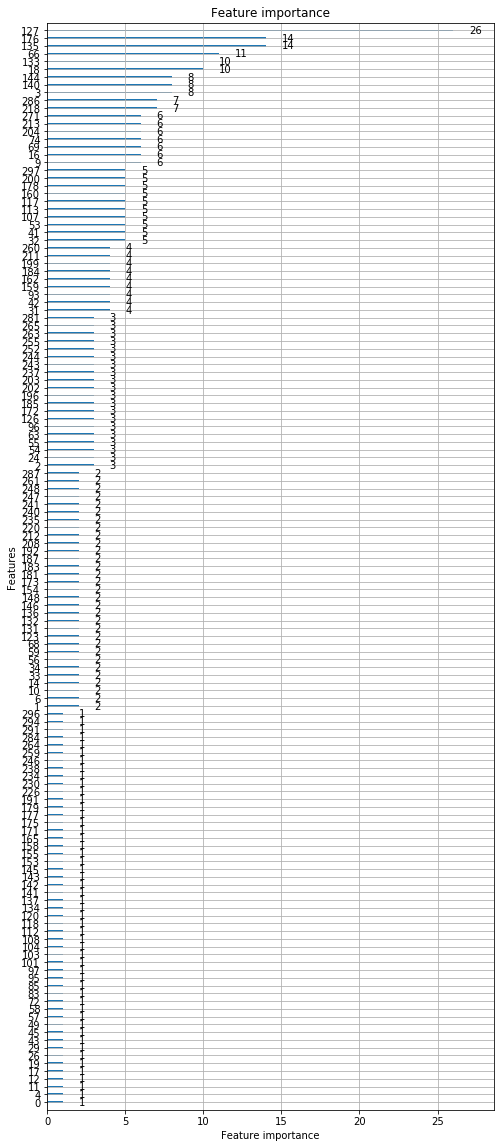

In [0]:
lgb.plot_importance(model, figsize=(8, 20))

In [0]:
pip install eli5

     |████████████████████████████████| 112kB 5.0MB/s 


In [0]:
import eli5
eli5.explain_weights_lightgbm(model)

AttributeError: ignored

In [0]:
pred = model.predict(test)
prediction = [1 if i >= 0.5 else 0 for i in pred]
pred2 = pd.DataFrame(prediction)
pred2.columns = ['target']

In [0]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
n_fold = 4
scores = []
scalar = StandardScaler()
model = LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
for tr_idx, va_idx in folds.split(X_train, y_train):
  train_x, valid_x = X_train[tr_idx], X_train[va_idx]
  train_y, valid_y = y_train[tr_idx], y_train[va_idx]

  model = LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')
  model.fit(train_x, train_y)
  va_pred = model.predict(valid_x).reshape(-1,)
  score = roc_auc_score(valid_y, va_pred)
  scores.append(score)

print(np.mean(scores))


0.6597226662404092


In [0]:
pip install eli5

     |████████████████████████████████| 112kB 4.7MB/s 


In [0]:
import eli5
eli5.show_weights(model,top=50)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Weight?,Feature
+1.349,x127
+0.690,x93
+0.672,x18
+0.589,x66
+0.502,x107
+0.501,x279
+0.437,x213
+0.387,x261
+0.334,x288
+0.333,x39


In [0]:
(model.coef_ != 0).sum()

98

In [0]:
top_features = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
X_train = train[top_features]
X_test = test[top_features]
n_fold = 4
scores = []
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
for tr_idx, va_idx in folds.split(X_train, y_train):
  train_x, valid_x = X_train[tr_idx], X_train[va_idx]
  train_y, valid_y = y_train[tr_idx], y_train[va_idx]

  model = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
  model.fit(train_x, train_y)
  va_pred = model.predict(valid_x).reshape(-1,)
  score = roc_auc_score(valid_y, va_pred)
  scores.append(score)

print(np.mean(scores))

ValueError: ignored